In [1]:
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Data Collection

Data collection includes querying for the relevant Google Flights data via SerpAPI to determine the average ticket costs for each of the four flight classes.

## `get_flight_data.py`

In [2]:
import pandas as pd
import serpapi
from enum import Enum
from datetime import datetime, timedelta
import numpy as np
import json

api_key = "cedab86e76f737c0f98719e2d13036ba598a8b26bcf9bfde0cda9c911a628336";

class TravelClass(Enum):
    ECONOMY = "1"
    PREMIUM_ECONOMY = "2"
    BUSINESS = "3"
    FIRST = "4"

class TripType(Enum):
    ROUND_TRIP = "1"
    ONE_WAY = "2"

class Airline(Enum):
    SINGAPORE_AIRLINES = "SQ"

# Number of stops during the flight
class NumStops(Enum):
    ANY = "0"
    NONSTOP = "1"
    ONE_OR_FEWER = "2"
    TWO_OR_FEWER = "3"

def generate_date_range(num_days, start_date = datetime.today() + timedelta(days=7)):
    """
    Generate yyyy-mm-dd date strings for the input number of days starting from start_date

    Inputs:
        num_days: Number of days from start_date to generate date string
        start_date: Start date. Defaults to 1 week from today

    Outputs:
        Returns an array of "yyyy-mm-dd" date strings from start_date ahead num_days
    """
    datelist = [d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, periods=num_days)]

    return datelist

def get_flight_data(dates = generate_date_range(1)):
    """
    Query SerpAPI Google Flights API for flights within `dates` date range. Saves dataframe as `flights.csv`
    in current directory.

    Inputs:
        dates: List of "yyyy-mm-dd" dates as flight outbound dates. Defaults to only flights departing one week from today.
    
    Outputs:
        Returns flight dataframe
    """

    flights_df = pd.DataFrame()

    # Default parameters:
    #   - SIN -> LHR
    #   - Only nonstop flights
    #   - Only Singapore Airlines flights
    params = {
        "engine": "google_flights",
        "departure_id": "SIN",
        "arrival_id": "LHR",
        "hl": "en",
        "gl": "us",
        "currency": "CAD",
        "show_hidden": "true",
        "stops": NumStops.NONSTOP.value,
        "include_airlines": Airline.SINGAPORE_AIRLINES.value,
    }

    # SerpAPI cannot aggregate results for each trip type and travel class so we need
    # to manually query for each
    #
    # NOTE: Currently only supports one way trips since we would have to add end dates which could
    # be too many queries for a free SerpAPI account
    for trip_type in [TripType.ONE_WAY]:
        for travel_class in TravelClass:
            for outbound_date in dates:
                params["type"] = trip_type.value
                params["travel_class"] = travel_class.value
                params["outbound_date"] = outbound_date

                client = serpapi.Client(api_key=api_key)
                results = client.search(params).as_dict()
                
                # API response is split into best_flights and other_flights arrays, combine them
                # in the final dataframe
                if "best_flights" in results:
                    best_flights_data = results["best_flights"]
                    best_flights_df = pd.json_normalize(best_flights_data)
                    flights_df = pd.concat([flights_df, best_flights_df])

                if "other_flights" in results:
                    other_flights_data = results["other_flights"]
                    other_flights_df = pd.json_normalize(other_flights_data)
                    flights_df = pd.concat([flights_df, other_flights_df])

    flights_df.to_csv("flights.csv")

    return flights_df

def get_flight_price_history_df(dates = generate_date_range(1)):
    """
    Query Google flights for historical flight price data, saved as a .csv and returned as a dataframe
    """
    flights_price_history_df = pd.DataFrame()

    params = {
        "engine": "google_flights",
        "departure_id": "SIN",
        "arrival_id": "LHR",
        "hl": "en",
        "gl": "us",
        "currency": "CAD",
        "show_hidden": "true",
        "stops": NumStops.NONSTOP.value,
        "include_airlines": Airline.SINGAPORE_AIRLINES.value,
    }

    for trip_type in [TripType.ONE_WAY]:
        for travel_class in TravelClass:
            for outbound_date in dates:
                params["type"] = trip_type.value
                params["travel_class"] = travel_class.value
                params["outbound_date"] = outbound_date
                #
                client = serpapi.Client(api_key=api_key)
                results = client.search(params).as_dict()
                # API response is split into best_flights and other_flights arrays, combine them
                # in the final dataframe
                if "price_insights" in results:
                    price_insights_data = results["price_insights"]
                    price_insights_df_row = pd.json_normalize(price_insights_data)
                    price_insights_df_row.insert(0, "travel_class", travel_class.value, True)
                    
                    flights_price_history_df = pd.concat([flights_price_history_df, price_insights_df_row])

    flights_price_history_df.to_csv("./price_history.csv")
    return flights_price_history_df

def get_min_flight_costs(flight_price_history_df):
    price_history_df  = flight_price_history_df[["travel_class", "price_history"]]

    for _, row in price_history_df.iterrows():
        price_history = json.loads(row["price_history"])
        travel_class = row["travel_class"]
        prices = []
        for time_price in price_history:
            prices.append(time_price[1])

        print(prices)
        print([travel_class, np.min(prices)])

    return 0

# Problem Solutions

### Loading Plane Area Data

In [3]:
areaDataframe = pd.read_csv('areaData.csv')
areaDataframe.head()
maxArea = areaDataframe['area'].values #in m^2
maxArea

array([15.9826, 16.3496, 15.9826, 22.8592, 25.9796, 25.4026, 18.9342,
       23.219 , 18.9342, 13.9573, 16.3496, 13.9573, 15.6434, 33.8954,
       15.6434, 20.7152, 37.2788, 20.7152,  9.5123, 19.0246,  9.5123,
        4.7508,  9.5016,  4.7508])

### Constants

In [4]:
n_classes = 4
n_sections = maxArea.size
seats = {}
cost = [864, 2054,5763,12184] # economic, premium, business, first
weight = [64,64,64,64] # economic, premium, business, first (in Kg)
max_weight = 395000 # in Kg
sizes = [0.39,0.478,1.06,1.829] # economic, premium, business, first (in m^2)

In [33]:
def solve_seating(solver, demand=[np.infty, 250, 50 ,24]):
    """
    Solve the A380 seating problem using Google OR-tools. Displays a histogram and
    a data frame with the seating arrangement.
    
    NOTE: Need to pass in a solver with the objective function set up already for the
    different scenarios.

    Params:
        solver: Google OR-tools solver with objective function and decision variables set

    """
    # Area constraint
    for j in range(n_sections):
        solver.Add(
            solver.Sum(seats[i, j] * (10**10 * sizes[i]) for i in range(n_classes)) <= (10**10 * maxArea[j])
        )

    # Weight constraint
    weight_constraint = solver.Sum(
        seats[i, j] * (10**10 * weight[i])
        for i in range(n_classes) 
        for j in range(n_sections)
    ) <= (10**10 * max_weight)

    # Demand constraint
    for i in range(n_classes):
        solver.Add(
            (solver.Sum(10**10 * seats[i, j] for j in range(n_sections)) <= ((10**10) * demand[i]))
        )

    # Solve the problem
    status = solver.Solve()

    # Get the optimal solution
    if status != pywraplp.Solver.OPTIMAL:
        print('The problem does not have an optimal solution.')
        # return


    # Create a histogram of each section and show the distribution of seats sold in each class
    fig, ax = plt.subplots()
    index = np.arange(n_sections)
    bar_width = 0.2
    opacity = 0.8
    class_labels = ['Economy', 'Premium', 'Business', 'First']

    data = []

    for i in range(n_classes):
        values = [seats[i, j].solution_value() for j in range(n_sections)]
        data.append(np.sum(values))
        ax.bar(index + i * bar_width, values, bar_width, alpha=opacity, label=class_labels[i])

    data.append(solver.Objective().Value())

    results_df = pd.DataFrame(
        data=[data],
        columns=["Economy", "Premium", "Business", "First", "Objective Value"]
    )

    print(results_df)

    ax.set_xlabel('Section')
    ax.set_ylabel('Seats')
    ax.set_title('Seats sold by section and class')
    ax.legend()

    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(index)

    #move the x axis +1 so counts start from 1
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [int(float(label)) + 1 for label in labels]
    ax.set_xticklabels(labels)

    fig.tight_layout()
    plt.show()

## Scenario 1: Demand follows Zipf - `demand=[np.infty, 250, 50 ,24]`

### Linear Programming

      Economy  Premium  Business  First  Objective Value
0  544.757949    250.0      50.0   24.0     1.564737e+06


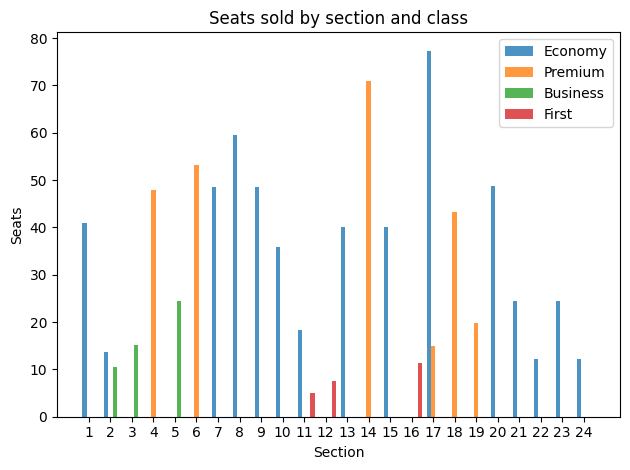

In [6]:
solver = pywraplp.Solver.CreateSolver('GLOP')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver)

### Integer Programming

The problem does not have an optimal solution.
[11.0, 4.0, 0.0, 4.0, 52.0, 27.0, 24.0, 38.0, 34.0, 21.0, 10.0, 10.0, 21.0, 82.0, 6.0, 15.0, 70.0, 41.0, 15.0, 41.0, 8.0, 1.0, 4.0, 4.0]
[20.0, 4.0, 12.0, 40.0, 2.0, 20.0, 20.0, 2.0, 3.0, 12.0, 26.0, 21.0, 0.0, 4.0, 1.0, 31.0, 17.0, 1.0, 0.0, 4.0, 0.0, 9.0, 1.0, 0.0]
[2.0, 0.0, 1.0, 2.0, 1.0, 5.0, 0.0, 7.0, 4.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 1.0, 6.0, 0.0, 7.0, 3.0]
[0.0, 7.0, 5.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]
   Economy  Premium  Business  First  Objective Value
0    543.0    250.0      50.0   24.0        1563218.0


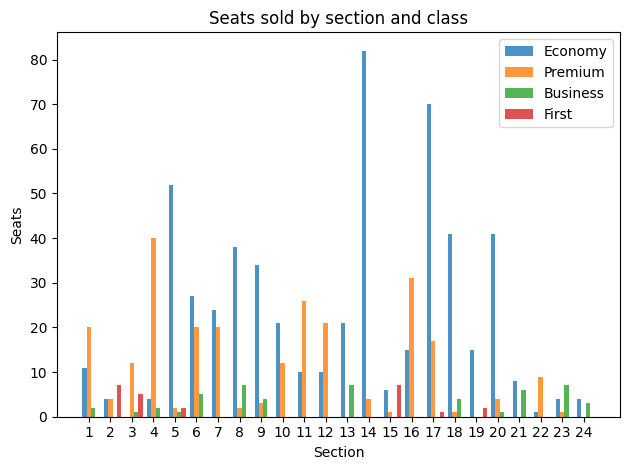

In [34]:
demand=[545, 250, 50 ,24]

solver = pywraplp.Solver.CreateSolver('SCIP')
solver.num_search_workers = 12
solver.SetTimeLimit(300 * 1000)

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

#### All Economy

   Economy  Premium  Business  First  Objective Value
0   1087.0      0.0       0.0    0.0         939168.0


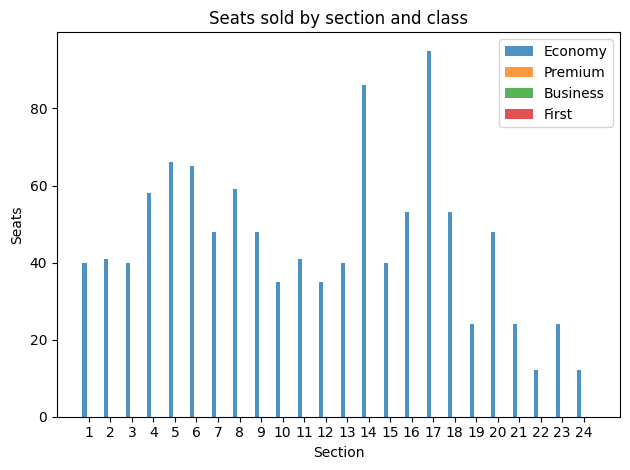

In [8]:
demand = [np.infty, 0, 0, 0]

solver = pywraplp.Solver.CreateSolver('SAT')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

#### All Premium Economy

   Economy  Premium  Business  First  Objective Value
0      0.0    883.0       0.0    0.0        1813682.0


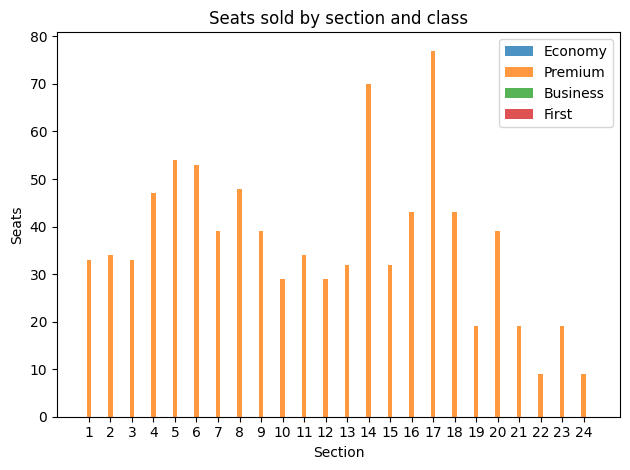

In [9]:
demand = [0, np.infty, 0, 0]

solver = pywraplp.Solver.CreateSolver('SAT')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

#### All Business

   Economy  Premium  Business  First  Objective Value
0      0.0      0.0     390.0    0.0        2247570.0


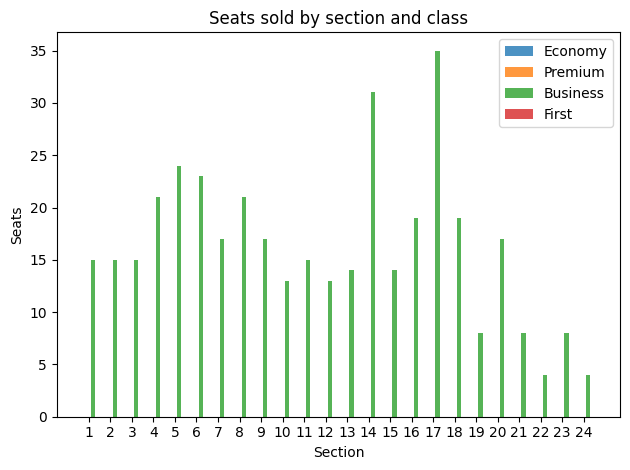

In [10]:
demand = [0, 0, np.infty, 0]

solver = pywraplp.Solver.CreateSolver('SAT')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

### All First Class

   Economy  Premium  Business  First  Objective Value
0      0.0      0.0       0.0  222.0        2704848.0


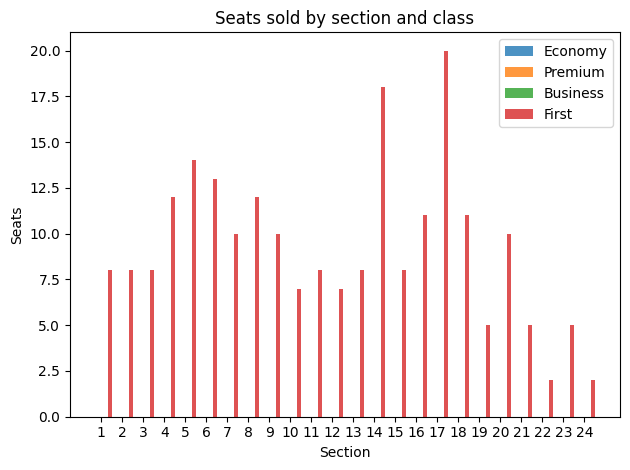

In [11]:
demand = [0, 0, 0, np.infty]

solver = pywraplp.Solver.CreateSolver('SAT')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

### Integer Programming with Regularization/Penalty Function

In [12]:
C = np.array([
    [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Econ
    [100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], # Prem. Econ
    [100, 100, 100, 0, 0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 50, 100, 100, 100, 100, 100, 100, 100, 100], # Business
    [0, 0, 0, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]  # First
])

cost_penalty_function = lambda x: x**2
cost_penalty_function_transform = np.vectorize(cost_penalty_function)
P = cost_penalty_function(C)

   Economy  Premium  Business  First  Objective Value
0    511.0    218.0      50.0   24.0        1469842.0


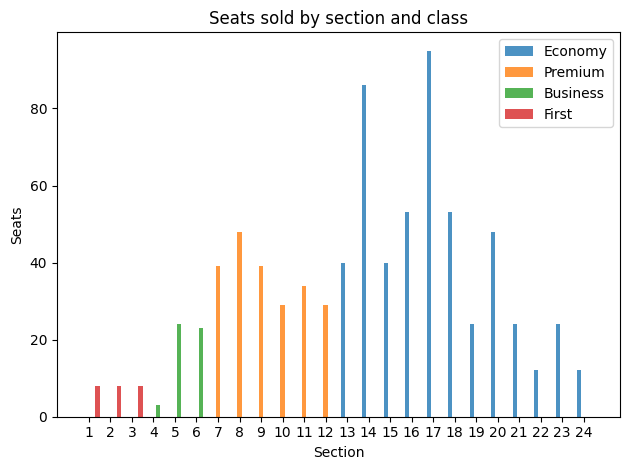

In [13]:
solver = pywraplp.Solver.CreateSolver('SAT')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(((seats[i,j] * cost[i]) - (seats[i, j] * P[i,j])) for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver)

### Greedy Solution

In [14]:
demand = [1200, 250,50,24] #economic, premium, business, first

#Remember the index of the original data
originalIndexArea = np.argsort(maxArea)

#Sort the areas in descending order
sorted_maxArea = np.sort(maxArea)

#Let's sort the variables that relates to classes by demand
sorted_demandIndex = np.argsort(demand)
sorted_demandIndex

cost = [cost[i] for i in sorted_demandIndex]
weight = [weight[i] for i in sorted_demandIndex]
demand = [demand[i] for i in sorted_demandIndex]
sizes = [sizes[i] for i in sorted_demandIndex]

#Initialize the decision variables
optimalRevenue = 0
optimalSeats = np.zeros((n_sections,n_classes))

In [15]:
#Greedy fill the smallest section area with the smallest demand class
for i in range(n_sections):
    #Check if the section has already have a selected class
    hasClassAssigned = False
    for j in range(n_classes):
        if (hasClassAssigned == True):
            break
        
        while demand[j] > 0 and max_weight > 0 and sorted_maxArea[i] > sizes[j]:
            hasClassAssigned = True
            max_weight -= weight[j]
            sorted_maxArea[i] -= sizes[j]
            demand[j] -= 1
            optimalRevenue += cost[j]
            optimalSeats[i,j] += 1
    hasClassAssigned = False

optimalRevenue

1510514

In [16]:
#Return the order of the sections to the original order
optimalSeats = optimalSeats[originalIndexArea,:]
optimalSeats

array([[ 0.,  0.,  0., 95.],
       [ 0.,  0.,  0., 66.],
       [ 0.,  0.,  0., 86.],
       [ 0.,  0.,  0., 65.],
       [ 0.,  0.,  0., 58.],
       [ 0.,  9.,  0.,  0.],
       [ 0.,  0., 34.,  0.],
       [ 0.,  0., 34.,  0.],
       [ 0.,  0., 39.,  0.],
       [ 2.,  0.,  0.,  0.],
       [ 5.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.],
       [ 0.,  0., 33.,  0.],
       [ 0., 14.,  0.,  0.],
       [ 0., 13.,  0.,  0.],
       [ 0.,  0.,  0., 59.],
       [ 0.,  0.,  0., 53.],
       [ 0.,  0., 39.,  0.],
       [ 5.,  0.,  0.,  0.],
       [ 0., 14.,  0.,  0.],
       [ 5.,  0.,  0.,  0.],
       [ 5.,  0.,  0.,  0.],
       [ 0.,  0., 39.,  0.],
       [ 0.,  0., 32.,  0.]])

In [17]:
#Print for each class the total number of seats
totalSeats = np.sum(optimalSeats, axis=0)

print('Total number of seats for each class')
print('Economic: ', totalSeats[3])
print('Premium: ', totalSeats[2])
print('Business: ', totalSeats[1])
print('First: ', totalSeats[0])

Total number of seats for each class
Economic:  482.0
Premium:  250.0
Business:  50.0
First:  24.0


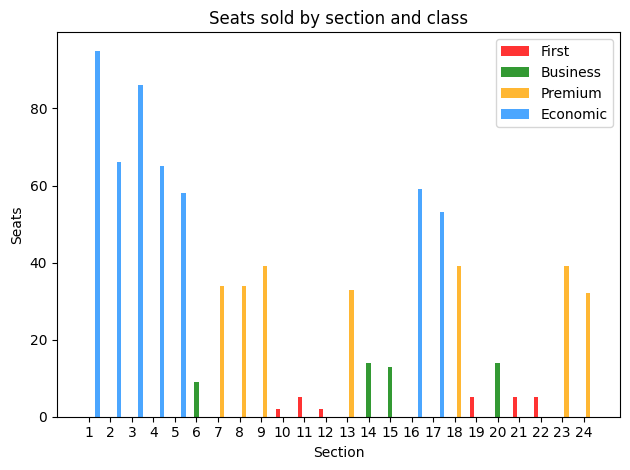

In [18]:
# Create a histogram of each section and show the distribution of seats sold in each class
fig, ax = plt.subplots()
index = np.arange(n_sections)
bar_width = 0.2
opacity = 0.8
class_labels = ['First', 'Business', 'Premium', 'Economic']

for i in range(n_classes):
    ax.bar(index + i*bar_width, optimalSeats[:,i], bar_width,
           color={"First":"red", "Business":"green", "Premium":"orange", "Economic":"dodgerblue"}[class_labels[i]],
           alpha=opacity,
           label=class_labels[i])

ax.set_xlabel('Section')
ax.set_ylabel('Seats')
ax.set_title('Seats sold by section and class')
ax.legend()

ax.set_xticks(index + bar_width)
ax.set_xticklabels(index)

#move the x axis +1 so counts start from 1
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(float(label)) + 1 for label in labels]
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

## Scenario 2: Match Singapore Airlines Demands - `demand=[825, 38, 60, 12]`

In [19]:
demand = [825, 38, 60, 12]

### Linear Programming

      Economy  Premium  Business  First  Objective Value
0  234.473264      0.0       0.0    0.0     2.856822e+06


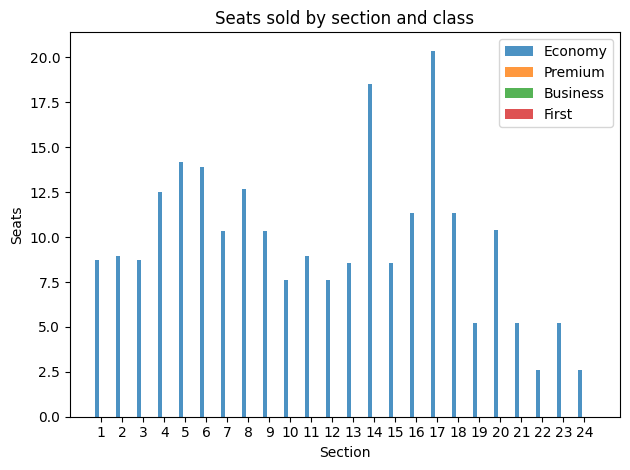

In [20]:
solver = pywraplp.Solver.CreateSolver('GLOP')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

### Integer Programming

In [21]:
# NOTE: The linear programming solution maxes out the economy seats at 833 so we can upper bound it to make it run a bit faster
demand = [833, 38, 60, 12]

   Economy  Premium  Business  First  Objective Value
0    222.0     10.0      16.0    1.0        2796206.0


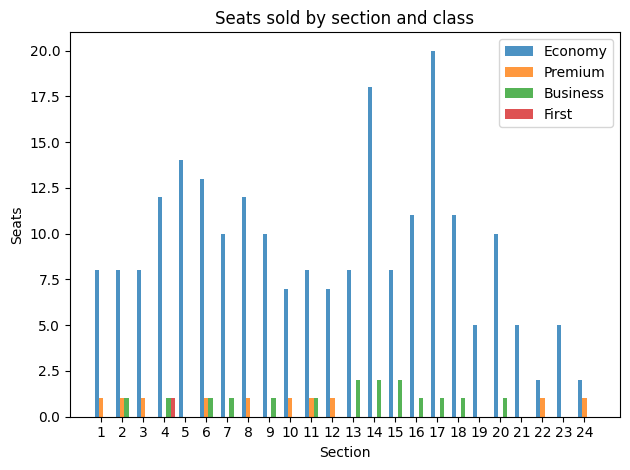

In [22]:
solver = pywraplp.Solver.CreateSolver('SAT')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(seats[i,j] * cost[i] for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

## IP with Regularization

In [23]:
C = np.array([
    [100, 100, 100, 100, 100, 100, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Econ
    [100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], # Prem. Econ
    [100, 100, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50], # Business
    [0, 0, 5, 5, 5, 5, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]  # First
])

cost_penalty_function = lambda x: x**2
cost_penalty_function_transform = np.vectorize(cost_penalty_function)
P = cost_penalty_function(C)

   Economy  Premium  Business  First  Objective Value
0    189.0     38.0      60.0   10.0        2352150.0


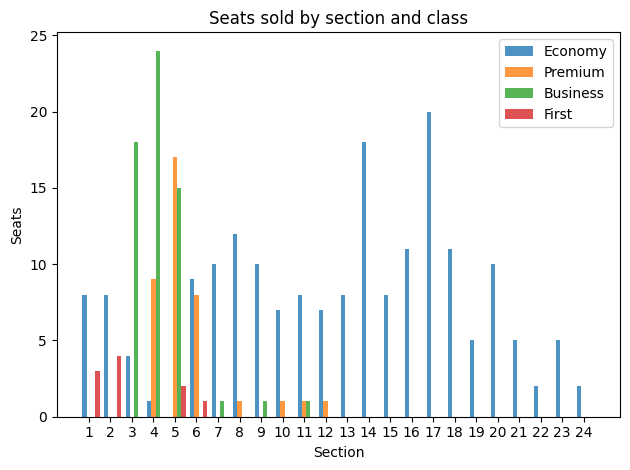

In [24]:
solver = pywraplp.Solver.CreateSolver('SAT')

for i in range(n_classes):
    for j in range(n_sections):
        seats[i, j] = solver.IntVar(0, solver.infinity(), f'seats_{i}_{j}')

# Define objective function
revenue = solver.Sum(((seats[i,j] * cost[i]) - (seats[i, j] * P[i,j])) for i in range(n_classes) for j in range(n_sections))

# Maximize revenue
solver.Maximize(revenue)

solve_seating(solver=solver, demand=demand)

### Greedy Solution

In [25]:
demand = [1200, 250,50,24] #economic, premium, business, first

#Remember the index of the original data
originalIndexArea = np.argsort(maxArea)

#Sort the areas in descending order
sorted_maxArea = np.sort(maxArea)

#Let's sort the variables that relates to classes by demand
sorted_demandIndex = np.argsort(demand)
sorted_demandIndex

cost = [cost[i] for i in sorted_demandIndex]
weight = [weight[i] for i in sorted_demandIndex]
demand = [demand[i] for i in sorted_demandIndex]
sizes = [sizes[i] for i in sorted_demandIndex]

#Initialize the decision variables
optimalRevenue = 0
optimalSeats = np.zeros((n_sections,n_classes))


In [26]:
#Greedy fill the smallest section area with the smallest demand class
for i in range(n_sections):
    #Check if the section has already have a selected class
    hasClassAssigned = False
    for j in range(n_classes):
        if (hasClassAssigned == True):
            break
        
        while demand[j] > 0 and max_weight > 0 and sorted_maxArea[i] > sizes[j]:
            hasClassAssigned = True
            max_weight -= weight[j]
            sorted_maxArea[i] -= sizes[j]
            demand[j] -= 1
            optimalRevenue += cost[j]
            optimalSeats[i,j] += 1
    hasClassAssigned = False

optimalRevenue

2197754

In [27]:
#Return the order of the sections to the original order
optimalSeats = optimalSeats[originalIndexArea,:]
optimalSeats

array([[ 0.,  0.,  0., 20.],
       [ 0.,  0.,  0., 14.],
       [ 0.,  0.,  0., 18.],
       [ 0.,  0.,  5.,  0.],
       [ 0.,  0., 21.,  0.],
       [ 0.,  0., 15.,  0.],
       [ 0.,  0., 15.,  0.],
       [ 0.,  0., 15.,  0.],
       [ 0.,  0., 17.,  0.],
       [12.,  0.,  0.,  0.],
       [ 0., 19.,  0.,  0.],
       [12.,  0.,  0.,  0.],
       [ 0.,  0., 15.,  0.],
       [ 0.,  0., 14.,  0.],
       [ 0.,  0., 13.,  0.],
       [ 0.,  0., 21.,  0.],
       [ 0.,  0., 19.,  0.],
       [ 0.,  0., 17.,  0.],
       [ 0., 19.,  0.,  0.],
       [ 0.,  0., 14.,  0.],
       [ 0.,  0., 13.,  0.],
       [ 0., 12.,  0.,  0.],
       [ 0.,  0., 17.,  0.],
       [ 0.,  0., 19.,  0.]])

In [28]:
#Print for each class the total number of seats
totalSeats = np.sum(optimalSeats, axis=0)

print('Total number of seats for each class')
print('Economic: ', totalSeats[3])
print('Premium: ', totalSeats[2])
print('Business: ', totalSeats[1])
print('First: ', totalSeats[0])

Total number of seats for each class
Economic:  52.0
Premium:  250.0
Business:  50.0
First:  24.0


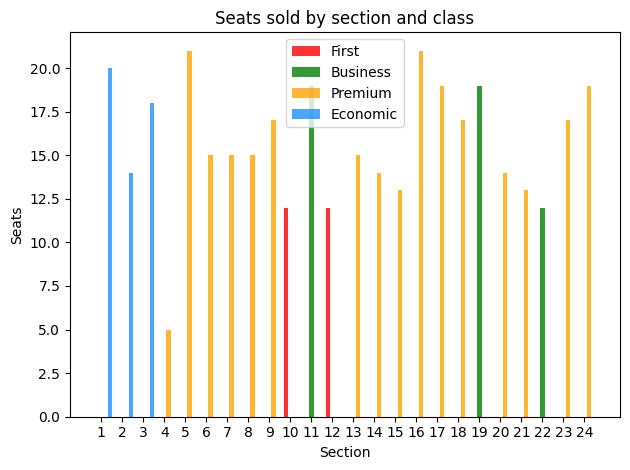

In [29]:
# Create a histogram of each section and show the distribution of seats sold in each class
fig, ax = plt.subplots()
index = np.arange(n_sections)
bar_width = 0.2
opacity = 0.8
class_labels = ['First', 'Business', 'Premium', 'Economic']

for i in range(n_classes):
    ax.bar(index + i*bar_width, optimalSeats[:,i], bar_width,
           color={"First":"red", "Business":"green", "Premium":"orange", "Economic":"dodgerblue"}[class_labels[i]],
           alpha=opacity,
           label=class_labels[i])

ax.set_xlabel('Section')
ax.set_ylabel('Seats')
ax.set_title('Seats sold by section and class')
ax.legend()

ax.set_xticks(index + bar_width)
ax.set_xticklabels(index)

#move the x axis +1 so counts start from 1
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [int(float(label)) + 1 for label in labels]
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

# Analysis

Simulate a ticket buying scenario for a random total number of customers and sampling the Zipf distribution for ticket counts.

In [30]:
def simulate_buying_tickets():
    """
    Sample from the Zipf distribution for some randomly selected demand.

    Returns:
    An array of tickets bought for each flight class.
    """
    # Total number of people buying tickets
    demand = np.random.lognormal(mean=np.log(800), sigma=0.2)

    # Sample from Zipf distribution the number of tickets per class
    samples = np.random.zipf(3, size=int(demand))

    # Clip samples to be within range [1, 4]
    samples = np.clip(samples, 1, 4)

    # Convert samples to integers
    samples = samples.astype(int)

    return np.histogram(samples, bins=np.arange(1, 6))[0]

def simulate_revenue(seating_arrs, num_iters=1000):
    """
    Simulate the ticket buying process for a given set of seats. Returns the average revenue.

    Params:
    - seating_arrs: array of seat counts (ordered by ascending value - economy, ..., first)
    - num_iters: number of trials to run simulating ticket buying

    Returns:
    - Average revenue for the given seating setup

    """
    prices = [864, 2054, 5763, 12184] #economic, premium, business, first

    total_revenues = []
    for _ in range(num_iters):
        ticket_counts = np.array(simulate_buying_tickets())

        ticket_counts[0] = min(ticket_counts[0], seating_arrs[0])
        ticket_counts[1] = min(ticket_counts[1], seating_arrs[1])
        ticket_counts[2] = min(ticket_counts[2], seating_arrs[2])
        ticket_counts[3] = min(ticket_counts[3], seating_arrs[3])

        ticket_prices = np.array(prices)

        revenue = np.dot(ticket_counts, ticket_prices)
        total_revenues.append(revenue)

    return np.average(total_revenues)

In [31]:

def simulate_revenue_and_display(seating_arrs):
    """
    Simulates and plots the average revenues for each of the given seating arrangements.

    Params:
    - seating_arrs: dictionary of seating scenario and seating arrangement

    Returns:
    - Array of average revenues
    """

    # Ordered the same as seating_arrs
    avg_revenues = []

    for seating_arr in seating_arrs.values():
        avg_revenue = simulate_revenue(seating_arr)
        avg_revenues.append(avg_revenue)

    # Display results
    plt.figure()

    seating_names = list(seating_arrs.keys()) 
    plt.barh(seating_names, avg_revenues)

    plt.suptitle("Average Revenue by Seating Arrangement")
    plt.show()
        
    return avg_revenues


### Revenue Comparison 

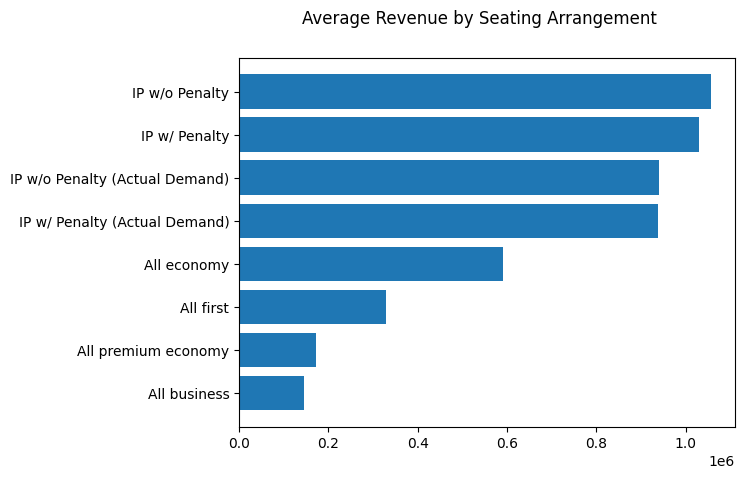

[144720.456,
 173423.328,
 328760.872,
 591353.568,
 937358.859,
 940529.703,
 1030956.99,
 1057752.023]

In [32]:
seating_arrs = {
    "All business": [0, 0, 390, 0], 
    "All premium economy": [0, 883, 0, 0],
    "All first": [0, 0, 0, 222],
    "All economy": [1087, 0, 0, 0],
    "IP w/ Penalty (Actual Demand)": [777, 38, 60, 12],
    "IP w/o Penalty (Actual Demand)": [825, 38, 60, 12],
    "IP w/ Penalty": [511, 218, 50, 24],
    "IP w/o Penalty": [543, 250, 50, 24],
}

simulate_revenue_and_display(seating_arrs)